## EDA

In [208]:
from __future__ import division
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import re
from HTMLParser import HTMLParser
import datetime
import cPickle as pickle

In [385]:
# Files that contain extracted names and summaries
sample10_file = '/Users/lekha/galvanize/capstone/projectRiley/data/sample10/out.txt'
sample1000_file = '/Users/lekha/galvanize/capstone/projectRiley/data/out1000.txt'
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/outall.txt'

In [210]:
pwd

u'/Users/lekha/galvanize/capstone/projectRiley/code'

In [387]:
cols = defaultdict(list)
num_rows = 0
with open(all_file) as f:
    for line in f:
        num_rows += 1
        n = line.split('||')
        cols['full_name'].append(n[0])
        cols['summary'].append(n[1])
        cols['html'].append(n[2])

df = pd.DataFrame(data=cols, index = np.arange(num_rows))

missing
shawn douglas
regina nunn
michael mayes
missing
jason obrien
kevin kim
amy chu
betty evans
jason cheng
jonathan nelson
kelly sullivan
jinhee lee
mark davis
michael shepherd
ben berkman
sara hill
scott wheeler
terry smith
missing
missing
richard johnson
amanda montgomery
mujtaba ahmed
kristiana henderson
jon jd schuler
roberto morales
mark hancock mnpl
ravi agarwal
pauline irawan
steve t
daniel unknown
brandon martin
steve obrien
john cook phd
phillip greer
missing
patty mulhern
ben paul
hageman sherri
aditya kulkarni
aakash maniyar
aalia brown
akrm almsaodi
aaron alva
aania aslam
aaron argiso
aaron barrell
aaron day
aaron browder
aaron buckner
aaron burke
aaron c
aaron campbell
aaron campeau
aaron cheuvront
aaron clubb
aaron daniels pmp
aaron m davis
aaron devor
aaron drake pmp
aaron emde
aaron fairchild
aaron faulk
aaron foreman
aaron guenther
aaron hawley
aaron ignac
aaron jarboe
aaron davidson
aaron garcia
aaron knight pe
aaron liss
aaron seeley
aaron mitchell jones
aaron mo

In [391]:
# add a counter of ones for doing some data analysis
df['counter'] = np.ones(len(df))

In [404]:
# debugging nonetype strings. Keeping the code since I seem to need it often
temp = df['full_name'].apply(lambda x: x.split())
print len(temp)
lens = []
for x in temp:
    lens.append(len(x))
    
print set(lens)

nplens = np.array(lens)
print np.where(nplens == 0)


(array([ 8568,  9638, 10864, 14465, 16045, 17267, 17294, 18146]),)


In [414]:
df.drop(df.index[[8568,  9638, 10864, 14465, 16045, 17267, 17294, 18146]], inplace=True)

In [415]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18184 entries, 0 to 18191
Data columns (total 4 columns):
full_name    18184 non-null object
html         18184 non-null object
summary      18184 non-null object
counter      18184 non-null float64
dtypes: float64(1), object(3)
memory usage: 710.3+ KB


In [416]:
# Add new column for first_name
df['first_name'] = df['full_name'].apply(lambda x: x.split()[0])

In [417]:
df = df[df['first_name'] != 'missing']

In [418]:
df = df[df['first_name'] != 'unicode-only']

In [419]:
df = df[df['first_name'].map(len) > 1]

In [420]:
len(df)

18047

## Gender Prediction using First Names

In [421]:
def gender_features(word):
    '''
    Returns the following features given a word:
    - name
    - last letter
    - last 2 letters
    - boolean if last letter is vowel
    '''
    return {'name': word, 'last_letter': word[-1], 'last_2_letters': word[-2:], 'last_is_vowel': (word[-1] in 'aeiou')}

In [450]:
def force_names(name, gender):
    females = ['aileen','jennifer', 'alyson', 'trinity', 'emily', 'mary',
               'nancy', 'betty','bridget', 'elizabeth','brittany', 
               'alexis','kimberly', 'lauren', 'sarah', 'heather', 'susan', 'amy', 'kim',
              'karen', 'erin', 'rachel','ashley','megan', 'kelly',
              'kymberly', 'aiden', 'elisabeth','marylou', 'harriet', 'apryl','meg', 'cindy', 'carmen',
              'joann', 'becky', 'meredyth', 'sheryl', 'tammy', 'rupal', 'maryann', 'carolynn', 'allison', 'edith',
              'rosemary', 'judith', 'sharon', 'pinar', 'stacy', 'stacey', 'helen', 'ginger', 'gretchen', 
              'jenifer', 'lois', 'meghan', 'holly', 'maureen', 'shabnam', 
              'colleen', 'kalleen', 'kaleen', 'hannah', 'tasneem', 'lindsay', 'margot', 'doris', 'shelley',
              'judy', 'courtney', 'brittanny','hillary', 'shirley', 'angel','anu', 'tracy', 'beth', 'sonal',
              'isabel']
    males = ['dave','mike', 'steve','kyle', 'aditya', 'ali', 'andre', 'joe', 'joshua',
            'gopi', 'krishna', 'robbie', 'jake', 'jorge', 'ravi', 'zakaria','nikolai','ronnie', 'royce', 'vance',
            'bruce', 'franklyn', 'mustafa', 'charlie', 'keshava']
    if name in females:
        return 'female'
    if name in males:
        return 'male'
    return gender

In [451]:
import nltk
from nltk.corpus import names

def gender_classifier(first_name):
    # 7944 labeled names from nltk corpus
    labeled_names = ([(name, 'male') for name in names.words('male.txt')] +[(name, 'female') for name in names.words('female.txt')])

    # nltk's NaiveBayesClassifier takes featuresets to train that is a tuple of (features_dict, label)
    featuresets_train = [(gender_features(name), gender) for (name, gender) in labeled_names]
    classifier = nltk.NaiveBayesClassifier.train(featuresets_train)
    
    # get the features of the set to be classified
    name_features = gender_features(first_name)
    g = classifier.classify(name_features)

    g = force_names(first_name, g)
    
    return g


df['gender'] = df['first_name'].apply(lambda x: gender_classifier(x))

In [453]:
df.gender.value_counts()

male      11071
female     6976
Name: gender, dtype: int64

In [454]:
# Write DF with gender to a text file
df.to_csv('../data/cleandatagenderall.txt', sep="|")

In [427]:
# Verification Cell for Classification Algorithm
train_set, test_set = featuresets[600:], featuresets[:500]
print classifier.classify(gender_features('rahul'))
print classifier.classify(gender_features('Trinity'))
print(nltk.classify.accuracy(classifier, test_set))
classifier.show_most_informative_features(5)

male
male
0.802
Most Informative Features
          last_2_letters = u'na'          female : male   =    106.4 : 1.0
          last_2_letters = u'la'          female : male   =     80.2 : 1.0
          last_2_letters = u'ia'          female : male   =     42.4 : 1.0
          last_2_letters = u'sa'          female : male   =     37.8 : 1.0
             last_letter = u'a'           female : male   =     35.4 : 1.0


In [455]:
df['first_name'].nunique()

4245

In [456]:
df_agg = df.groupby(['gender','first_name']).agg({'counter':sum})

In [457]:
#group by the first level of the index
g = df_agg['counter'].groupby(level=0, group_keys=False)

In [444]:
# sort by the count of the first names
g.nlargest(50)

gender  first_name
female  jennifer      154
        sarah         123
        jessica       117
        lisa           88
        michelle       81
        mary           79
        laura          77
        stephanie      74
        amy            69
        susan          65
        julie          64
        amanda         60
        heather        56
        joe            54
        nicole         54
        rebecca        54
        lauren         50
        anna           48
        sara           48
        christine      46
        katie          46
        andrea         43
        christina      43
        katherine      43
        melissa        43
        angela         42
        joshua         41
        kimberly       40
        julia          37
        catherine      35
                     ... 
male    elizabeth      79
        emily          79
        matt           79
        richard        77
        alex           72
        dan            72
        jonathan   

In [460]:
females = df[df['gender'] == 'female']
males = df[df['gender'] == 'male']

In [461]:
females['first_name'].nunique()

1851

In [462]:
males['first_name'].nunique()

2394

In [463]:
set(males['first_name'])

{'eivind',
 'trenton',
 'andry',
 'andre',
 'francesco',
 'roosvelt',
 'aswin',
 'pedro',
 'pasang',
 'marcos',
 'paris',
 'kentaro',
 'edward',
 'yichao',
 'regan',
 'applied',
 'itzam',
 'every',
 'jack',
 'jacob',
 'stevanus',
 'raymon',
 'akash',
 'charmin',
 'hossein',
 'shaughn',
 'sxean',
 'venus',
 'sachin',
 'eileen',
 'gongguo',
 'chet',
 'abdulrahman',
 'hanah',
 'codin',
 'ashkaan',
 'arwen',
 'lian',
 'kymber',
 'gorman',
 'chen',
 'melvin',
 'ryland',
 'yitung',
 'seunghyun',
 'ruben',
 'shishir',
 'ned',
 'naarah',
 'neb',
 'pawel',
 'ayman',
 'liah',
 'cheng',
 'sheffield',
 'liberto',
 'ghungru',
 'mrityunjay',
 'jayson',
 'athar',
 'zach',
 'avery',
 'mel',
 'drew',
 'beck',
 'jarrod',
 'brooks',
 'bogdan',
 'gerry',
 'michal',
 'ansgar',
 'wenyu',
 'leland',
 'ty',
 'sangbin',
 'karim',
 'karin',
 'lyubov',
 'joshua',
 'kieran',
 'bry',
 'guangtong',
 'kyryl',
 'shun',
 'zijing',
 'yanyan',
 'xuyao',
 'anupam',
 'nikolaos',
 'ambreen',
 'juemin',
 'robertson',
 'tk',

In [58]:
x = zip(fnames, gender_fnames1)
with open('gender1000.txt', 'w') as f:
    for line in x:
        name = line[0]
        g = line[1]
        nameg = name + "," + g + "\n"
        f.write(nameg)
        #f.write("\n")

In [160]:
letter_freq = df.last_letter.value_counts()
letter_freq.sort_values(ascending=False, inplace=True)


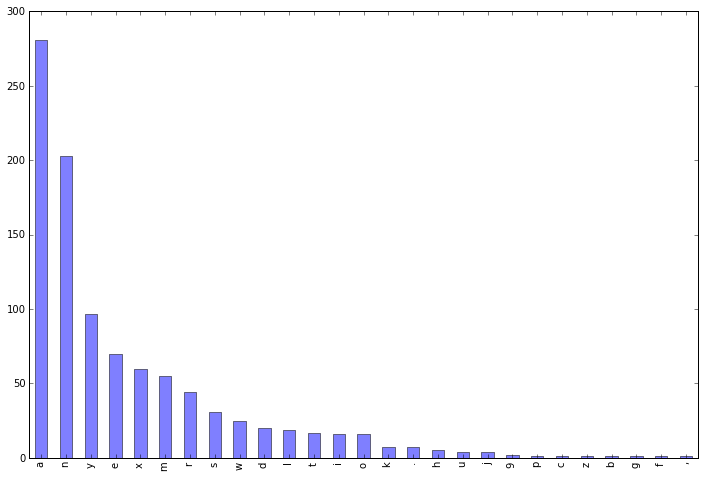

In [161]:
# Plot one of the features for gender prediction: last letter
fig, ax = plt.subplots()
letter_freq.plot(ax=ax, kind='bar', alpha = 0.5, figsize=(12,8))